### Information on our system

In [1]:
import sys
import os

import warnings
warnings.filterwarnings('ignore')

print(sys.version)

3.7.7 (tags/v3.7.7:d7c567b08f, Mar 10 2020, 10:41:24) [MSC v.1900 64 bit (AMD64)]


### Installing requirements to download packages 

In [2]:
!pip freeze > requirements.txt;
!pip install requirements.txt;

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt;'
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


### Reproductible Results

In [3]:
from numpy.random import seed
seed(1337)

### Import necessited packages

In [4]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from keras_tqdm import TQDMNotebookCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import keras

from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import TensorBoard
from keras import backend as K

import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

Using TensorFlow backend.


### Path

In [5]:
path = r'~/Desktop/MLP_Project/'

In [6]:
# For the Pre-Process
test_size = 0.30

### Functions 
#### Plots

In [7]:
def acc_loss(nn_it):
    plt.style.use('ggplot')
    
    acc = nn_it.history['acc']
    val_acc = nn_it.history['val_acc']
    loss = nn_it.history['loss']
    val_loss = nn_it.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

def check_stratify(y_train, y_test):
    if np.count_nonzero(y_test)/len(y_test) == np.count_nonzero(y_train)/len(y_train):
        print("We are good to go ! train_test_split well stratified: {} for y_test and {} for y_train".format(np.count_nonzero(y_test)/len(y_test), np.count_nonzero(y_train)/len(y_train)))
    else:
        print("train_test_split not well stratified: {} for y_test and {} for y_train".format(np.count_nonzero(y_test)/len(y_test), np.count_nonzero(y_train)/len(y_train)))
        
def cbk(epoch, logs):
    t.set_postfix(logs, refresh = False)
    t.update()   
cbkWrapped = keras.callbacks.LambdaCallback(on_epoch_end = cbk)

#### Metrics

In [8]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

### Pre-Process

In [9]:
df = pd.read_csv(os.path.join(path,"credit_scoring.csv"))


df = df.rename(columns = {'Unnamed: 0':'Client_ID'})
df = df.drop(columns = ['Client_ID'])
df.loc[df.Cible == 1, 'Cible'] = 0
df.loc[df.Cible == 2, 'Cible'] = 1

for col in ['Comptes', 'Historique_credit', 'Objet_credit', 'Epargne', 'Anciennete_emploi', 'Situation_familiale', 'Garanties', 'Biens', 'Autres_credits', 'Statut_domicile', 'Type_emploi', 'Telephone', 'Etranger']:
    df[col] = df[col].astype('category')
    
labels = df['Cible'].values
features = pd.get_dummies(df)
features = features.drop(columns = ['Cible'])
features_list = list(features.columns)

features = np.array(features)
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=test_size, random_state=1337, stratify = labels)

scaler = StandardScaler()  
scaler.fit(X_train)
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

Training Features Shape: (700, 61)
Training Target Shape: (700,)
Testing Features Shape: (300, 61)
Testing Target Shape: (300,)


The idea here is to check if the split between the train and test set is indeed stratified

In [10]:
check_stratify(y_train, y_test)

We are good to go ! train_test_split well stratified: 0.3 for y_test and 0.3 for y_train


# Multi-Layers Perceptron

### Using Keras

The idea is to create a Multi-Layers Perceptron using Keras.  
Keras is a simple tool for constructing a neural network. It is a high-level framework based on **tensorflow**, **theano** or **cntk** backends.  
**Sequential** specifies to keras that we are creating model sequentially and the output of each layer we add is input to the next layer we specify.  
**model.add** is used to add a layer to our neural network. We need to specify as an argument what type of layer we want. The **Dense** is used to specify the fully connected layer.  
For example in the code below we have:
* An input layer which dimensions **equals to the number of features** we have after one hot encoding (input_dim = 61),
* 1-th hidden layer that has **256** hidden neurons, with a **rectified linear unit** (ReLU) as activation function,
* An output layer with **1** hidden neurons, with a sigmoid as activation function.  

Parameters:
* ```units```: The units are the most basic parameter to understand. This parameter is a positive integer that denotes the **output size of the layer**.
* ```kernal_initializer```: The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for **which statistical distribution or function to use** for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights. Hence, numbers are going to be generated from a **Uniform** distribution.
* ```activation```: Activation function to use. If you don't specify anything, no activation is applied (ie. "linear" activation: $a(x) = x$). Common activation functions are : **Sigmoid**, **reLu**, **tanH**, **Leaky reLu** and so on..

#### Parameters for Keras

In [11]:
input_dim = X_train.shape[1] # Number of features

#### Model

In [12]:
def Keras_Simple_Model():
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Dense(units = 256,
                  kernel_initializer = 'uniform',
                  activation = 'relu',
                  input_dim = input_dim)(inputs)
    layer = Dense(1, activation='sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

We instantiate our first Keras model to make **classifier**. 
We then compile our model using the following argument:
* ```loss = 'binary_crossentropy'``` : As part of the optimization algorithm, the error for the current state of the model must be estimated repeatedly. This requires the **choice of an error function**, conventionally called a loss function, that can be used to estimate the loss of the model so that the weights can be updated to reduce the loss on the next evaluation. As we are dealing with a **classification problem**, binary_crossentropy is the function we want to choose.
* ```optimizer = 'adam'```: It seems the [Adaptive Moment Estimation (Adam)](https://ruder.io/optimizing-gradient-descent/) optimizer **nearly always works better** (faster and more reliably reaching a global minimum) when minimising the cost function in training neural nets. This is why we will not even bother trying another one.
* ```metrics = 'acc'```: Obviously we want to maximize accuracy.

In [13]:
classifier = Keras_Simple_Model()
classifier.compile(loss = 'binary_crossentropy',
                   optimizer = 'adam',
                   metrics = ['mse', 'acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


It is about time to fit our model:
* ```validation_data = (X_train, X_test)```: arbitrary choice of a validation set.
* ```batch_size = 32```: The batch size is a hyperparameter that defines the **number of samples** to work through before updating the internal model parameters. Think of a batch as a for-loop iterating over one or more samples and making predictions. At the end of the batch, the **predictions are compared to the expected output variables and an error is calculated**. From this error, the update algorithm is used to improve the model, e.g. move down along the error gradient. In the case of mini-batch gradient descent, popular batch sizes include 32, 64, and 128 samples. You may see these values used in models in the literature and in tutorials.
* ```epochs = 20```: The number of epochs is a hyperparameter that defines the **number times** that the learning algorithm will work through the entire training dataset. One epoch means that each sample in the training dataset has had an opportunity to update the internal model parameters. An epoch is comprised of one or more batches. For example, as above, an epoch that has one batch is called the batch gradient descent learning algorithm. You can think of a for-loop over the number of epochs where each loop proceeds over the training dataset. Within this for-loop is another nested for-loop that iterates over each batch of samples, where one batch has the specified “batch size” number of samples. In our case, **epoch does not really matter as we use early stopping**.
* ```EarlyStopping```: Stop training when a **monitored quantity has stopped improving** (in our case Validation Loss). Here the monitored quantity is validation loss in order to avoid overfitting. **min_delta** correspond to minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.

In [14]:
%%time
Keras_Simple_Model = classifier.fit(X_train, y_train,
                                    validation_data=(X_test, y_test),
                                    batch_size = 32,
                                    epochs = 20,
                                    callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001), TQDMNotebookCallback()],
                                    shuffle = True,
                                    verbose = 0)


Wall time: 674 ms


# The Neural Network Architecture

Every single Neural Network has three types of layers: **input**, **hidden**, and **output**.

#### How to calculate the Input Layer size?

With respect to the number of neurons comprising this layer, this parameter is **uniquely determined** once you know the shape of your training data. Specifically, the number of neurons comprising that layer is equal to the **number of features** in your data. That is why in our code we have ```shape=[input_dim]``` with ``` input_dim = X_train.shape[1] ```

#### How to calculate the number of Hidden Layers ?
If your data is linearly separable then you don't need any hidden layers at all. Of course, you don't need an Neural Network to resolve your data either, but it will still do the job. In our case, our data are definitely not linearly separable.  
One thing that is important to notice is that there is **no consensus** on how to choose the number of hidden layers. Even tough there are several basic rules that helps building a better Neural Networks architecture, we need to keep in mind that Machine Learning and especially NN are empirical-driven (experiment > theory). The situations in which performance improves with a second (or third, etc.) hidden layer are very few.

#### How to calculate the number of Hidden Neurons per Hidden Layer ?
There are some empirically-derived rules-of-thumb, of these, the most commonly relied on is *'the optimal size of the hidden layer is usually between the size of the input and size of the output layers'*. Hence, if n is the size of the hidden layer, in our case we have **61 < n < 1**.  
According to [Neural Network Design](http://hagan.okstate.edu/NNDesign.pdf#page=469) there is one additional rule of thumb that helps for supervised learning problems. You can usually prevent over-fitting if you keep your number of neurons below:  

$$N_h = \frac{N_s} {(\alpha * (N_i + N_o))}$$

**$N_i$**  = number of input neurons.  
**$N_o$** = number of output neurons.  
**$N_s$** = number of samples in training data set.  
**$\alpha$** = an arbitrary scaling factor usually 2-10. 


They also advice, for an automated procedure, to start with an alpha of **2** (twice as many degrees of freedom in your training data as your model) and work your way up to 10 if the error (loss) for your training dataset is significantly smaller than for your test dataset.

#### How to calculate the Output Layer size ?
Like the Input layer, every Neural Network has exactly one output layer. Determining its size (number of neurons) is simple; it is completely determined by the chosen model configuration.
If the NN is a classifier, then it also has a single node unless **softmax** is used in which case the output layer has one node per class label in your model. As we do not use softmax, our Output Layer consist of a single node: ```layer = Dense(1, activation = 'sigmoid')(layer)```

# Optimization of the Network Architecture
According to [An Iterative Pruning Algorithm for Feedforward Neural Networks (1997)](https://www.dsi.unive.it/~pelillo/papers/IEEE-TNN%2097.pdf):  
The problem of determining the proper size of an artificial neural network is recognized to be crucial, especially for its practical implications in such important issues as **learning** and **generalization**. One popular approach tackling this problem is commonly known as pruning and consists of training a larger than necessary network and then removing unnecessary weights/nodes.

According to [Pruning Algorithms of Neural Networds - a comparative study](https://www.degruyter.com/downloadpdf/j/comp.2013.3.issue-3/s13537-013-0109-x/s13537-013-0109-x.pdf):   
**Pruning** describes a set of techniques to trim network size (by nodes not layers) to improve computational performance and sometimes resolution performance. The gist of these techniques is removing nodes from the network during training by identifying those nodes which, if removed from the network, would not noticeably affect network performance (i.e., resolution of the data). (Even without using a formal pruning technique, you can get a rough idea of which nodes are not important by looking at your weight matrix after training; look weights very close to zero--it's the nodes on either end of those weights that are often removed during pruning.) Obviously, if you use a pruning algorithm during training then begin with a network configuration that is more likely to have excess (i.e., 'prunable') nodes--in other words, when deciding on a network architecture, err on the side of more neurons, if you add a pruning step.

There are lot of research paper on genetic-algortihm used in order to approach optimal netword configuration in a single up-front. How-ever, the two-steps optimization cited above is more common.

# Hyperparameter Optimization through Keras
Even though there are several ways in order to optimize hyperparameters (Manual, Machine-Assisted, Algorithmic), we will focus on the Machine-Assisted.
In Keras there are different methods: TensorBoard GridSearch RandomizedSearch and so on...  
In our case we will use [TensorBoard](https://www.tensorflow.org/tensorboard). 

In order to have access to TensorBoard, do not forget to ```pip3 install tensorboard``` in the cmd prompt.  

The first step is to define the space of hyper-parameters we want to go through:

```python
dense_layers = [1]
layer_sizes = [6, 12, 18]
layer_sizes_2 = [2, 4, 6]
batch_sizes = [1, 16, 32]
```

We then loop over each list in order to create all possible pairs:
``` python
for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for layer_size_2 in layer_sizes_2:
            for batch_size in batch_sizes:
```

In order to recognize what model is in the log, we define a **NAME** variable that will define what model we are currently training.  
The last step is just to introduce the TensorBoard: 
```python 
tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))
```

In [1]:
%%time
dense_layers = [1]
layer_sizes = [6, 12, 18]
layer_sizes_2 = [2, 4, 6]
batch_sizes = [1, 16, 32]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for layer_size_2 in layer_sizes_2:
            for batch_size in batch_sizes:
                
                NAME = "{}-nodes_layer1-{}-nodes_layer2-{}-batch_size".format(layer_size, layer_size_2, batch_size)
                tensorboard = TensorBoard(log_dir = 'logs/{}'.format(NAME))
                print(NAME)

                model = Sequential()

                for l in range(dense_layer):
                    model.add(Dense(layer_size,
                                    kernel_initializer = 'normal',
                                    input_dim = X_train.shape[1]))
                    model.add(Dense(layer_size_2))

                model.add(Dense(1))
                model.add(Activation('sigmoid'))

                model.compile(loss = 'binary_crossentropy',
                              optimizer = 'adam',
                              metrics = ['acc'])
                model.fit(X_train, y_train,
                          validation_data=(X_test, y_test), batch_size = batch_size,
                          epochs = 100,
                          callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001), tensorboard, TQDMNotebookCallback()],
                          shuffle = True,
                          verbose = 0)

NameError: name 'TensorBoard' is not defined

What we have now is a ```logs``` directory. In order to read those results into TensorBoard, simply write the following command in your ```cmd```:  
```tensorboard --logdir=path\to\logs --host localhost --port 8088```  
Open a web browser and as the URL put:  
```http://localhost:8088/```


Here are the result from our different Neural Networks.

![TensorBoard Result](pictures/TensorBoardResult.png)

[![Val_Loss](https://i.gyazo.com/aae0aa46a021ed920c04363994ccb5b5.gif)](https://gyazo.com/aae0aa46a021ed920c04363994ccb5b5)

Here is the Validate Loss Value for each Neural Networks we trained by descending value:

![Validation Loss](pictures/val_loss_descc.png)

#### Conclusion:
The retained model is the one with the least Validation Loss value: **6 nodes** for the 1-th hidden layer, **6 nodes** for the 2-th hidden layer

In [16]:
def Best_Model():
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Dense(units = 12,
                  kernel_initializer = 'uniform',
                  input_dim = input_dim)(inputs)
    layer = Dense(units = 6)(layer)
    layer = Dense(1, activation = 'sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

classifier = Best_Model()
classifier.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['mse', 'acc'])

nn_it = classifier.fit(X_train, y_train,
                       validation_data=(X_test, y_test), batch_size = 16,
                       epochs = 100,
                       callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001), TQDMNotebookCallback()],
                       shuffle = True,
                       verbose = 0)

[[172  38]
 [ 35  55]]


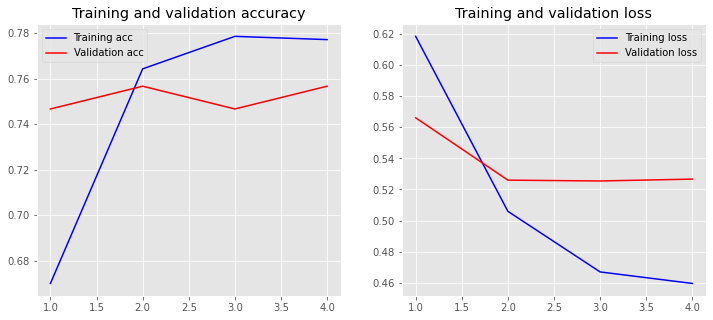

In [17]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)


acc_loss(nn_it)

#### How to calculate optimal batch size ?
Minibatch sizes are generally driven by the following factors:

* **Larger batches provide a more accurate estimate of the gradient**, but with less than linear returns.
* Multicore architectures are usually underutilized by extremely small batches. This motivates using some**absolute minimum batch size**, below which there is no reduction in the time to process a minibatch.
* If all examples in the batch are to be processed in parallel (as is typically thecase), then the amount of memory scales with the batch size. For many hardware setups this is the limiting factor in batch size.
* Some kinds of hardware achieve better runtime with speciﬁc sizes of arrays. Especially when using GPUs, it is common for power of 2 batch sizes to offer better runtime. **Typical power of 2 batch sizes range from 32 to 256, with 16 sometimes being attempted for large models**.
* **Small batches can offer a regularizing effect** (Wilson and Martinez, 2003), perhaps due to **the noise they add** to the learning process. **Generalization error is often best for a batch size of 1**. Training with such a small batch size might require a small learning rate to maintain stability because of the high variance in the estimate of the gradient. The total runtime can be very high as a result of the need to make more steps, both because of the reduced learning rate and because it takes more steps to observe the entire training set.  

#### Conclusion:
* Estimation of the gradient is better with larger batch sizes.
* Depends if you are running on GPU or CPU (in our case CPU). If so, specific sizes of arrays (power of 2) offers better runtime.
* Small batches add noise to the learning process. Generalization error is often best for **batch_size = 1**.

In [18]:
%%time 

nn_it = classifier.fit(X_train, y_train,
                       validation_split=0.20,
                       batch_size = 100,
                       epochs = 20,
                       callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001), TQDMNotebookCallback()],
                       verbose = 0)



Wall time: 79.9 ms


Prediction then computing the confusion matrix

[[171  39]
 [ 34  56]]


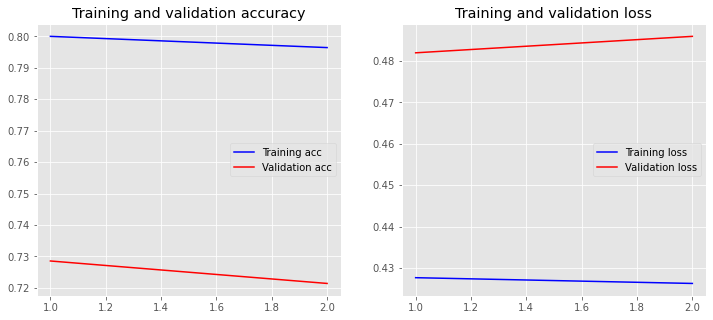

In [19]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)


acc_loss(nn_it)

In [20]:
loss, mse, accuracy = classifier.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, mse, accuracy = classifier.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7843
Testing Accuracy:  0.7567


Another model:  
For example here we have:
* An input layer equals to the number of features we have after one hot encoding (input_dim = 61),
* 1-th hidden layer that has 6 hidden neurons, with an uniform distribution as kernel_initializer,
* 2-th hidden layer that 2 hidden neurons,
* Output layer, with a sigmoid activation function


[[171  39]
 [ 36  54]]
Wall time: 4.75 s


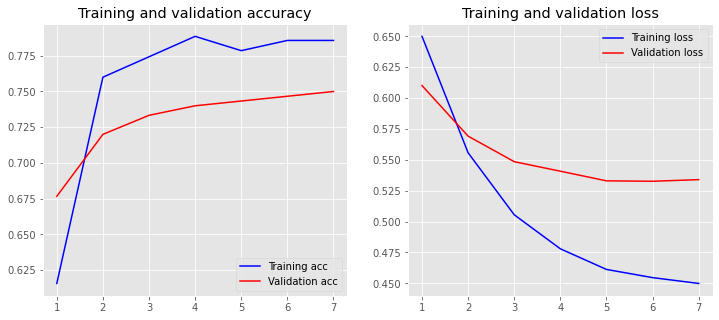

In [21]:
%%time
def Keras_Model():
    inputs = Input(name='inputs', shape=[input_dim])
    layer = Dense(units = 6,
                  kernel_initializer = 'uniform',
                  input_dim = input_dim)(inputs)
    layer = Dense(units = 2)(layer)
    layer = Dense(1, activation = 'sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

classifier = Keras_Model()
classifier.compile(loss = 'binary_crossentropy',
                   optimizer = 'adam',
                   metrics = ['acc', f1_m,precision_m, recall_m])


nn_it = classifier.fit(X_train, y_train,
                       validation_data=(X_test, y_test), batch_size = 16,
                       epochs = 100,
                       callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001), TQDMNotebookCallback()],
                       shuffle = True,
                       verbose = 0)



y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)


acc_loss(nn_it)

In [22]:
loss_NN_train, accuracy_NN_train, f1_score_NN_train, precision_NN_train, recall_NN_train = classifier.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy : {:.4f}".format(accuracy_NN_train))
print("Training F1-Score : {:.4f}".format(f1_score_NN_train))
print("Training Precision: {:.4f}".format(precision_NN_train))
print("Training Recall   : {:.4f}".format(recall_NN_train))
print("==========================")
loss_NN_test, accuracy_NN_test, f1_score_NN_test, precision_NN_test, recall_NN_test = classifier.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy :  {:.4f}".format(accuracy))
print("Testing F1-Score :  {:.4f}".format(f1_score))
print("Testing Precision:  {:.4f}".format(precision))
print("Testing Recall   :  {:.4f}".format(recall))

Training Accuracy : 0.7929
Training F1-Score : 0.5971
Training Precision: 0.6861
Training Recall   : 0.5450
Testing Accuracy :  0.7500
Testing F1-Score :  0.5844
Testing Precision:  0.6125
Testing Recall   :  0.6003


# Generalization  
## Overfitting  

In Machine Learning, **overfitting** means models perform well on the training data but don’t generalize well for new data. This happens when the model is too complex relative to the amount and noisiness of the training data.  
In other words, overfitting (or underfitting) occurs when a model is too specific (or not specific enough) to the training data, and doesn't extrapolate well to the true domain.  
This picture explains well what is overfitting:
![overfitting](https://i.stack.imgur.com/NNj3k.png?s=256)

Clearly, the green line, a decision boundary trying to separate the red class from the blue, is "overfitting", because although it will do well on the training data, it lacks the "regularized" form we like to see when generalizing.  

### When does overfitting occur, generally?  
Obviously, the testing error will always (in expectation) be worse than the training error, but at a certain number of iterations, the loss in testing will start to increase, even as the loss in training continues to decline.  

### How to tell when a model has overfit visually?  
Plotting Train and Validation losses allows us to detect possible overfitting.  

Here is an example with a graph from [fast.ai](https://forums.fast.ai/t/determining-when-you-are-overfitting-underfitting-or-just-right/7732/9):
![loss_tr_val](https://i.stack.imgur.com/dN7nBm.png)

Two things we can observe from this graph:
* The training loss keeps decreasing after every epoch. Our model is learning to recognize the specific labels in the training set.
* The validation loss keeps increasing after every epoch. Our model is not generalizing well enough on the validation set.


To illustrate some classical intuition about overfitting and model complexity, we given an example using polynomials. Given training data consisting of a single feature  $x$  and a corresponding real-valued label  $y$ , we try to find the polynomial of degree  $d$

$$\hat{y}= \sum_{i=0}^d x^i w_i$$

to estimate the labels  $y$ . This is just a linear regression problem where our features are given by the powers of  $x$, the  $wi$  given the model’s weights, and the bias is given by  $w_0$  since  $x0=1$  for all  $x$. Since this is just a linear regression problem, we can use the squared error as our loss function.  

A higher-order polynomial function is more complex than a lower order polynomial function, since the higher-order polynomial has more parameters and the model function’s selection range is wider. Fixing the training dataset, higher-order polynomial functions should always achieve lower (at worst, equal) training error relative to lower degree polynomials. In fact, whenever the data points each have a distinct value of  x , a polynomial function with degree equal to the number of data points can fit the training set perfectly. We visualize the relationship between polynomial degree and under- vs over-fitting in the next figure.

![over](http://d2l.ai/_images/capacity_vs_error.svg)

### Dataset size

The other big consideration to bear in mind is the dataset size. Fixing our model, the fewer samples we have in the training dataset, the more likely (and more severely) we are to encounter overfitting. As we increase the amount of training data, the generalization error typically decreases. Moreover, in general, more data never hurts. For a fixed task and data distribution, there is typically a relationship between model complexity and dataset size. Given more data, we might profitably attempt to fit a more complex model. Absent sufficient data, simpler models may be difficult to beat. For many tasks, deep learning only outperforms linear models when many thousands of training examples are available. In part, the current success of deep learning owes to the current abundance of massive datasets due to Internet companies, cheap storage, connected devices, and the broad digitization of the economy.


## How to prevent overfitting ?

Here are the most common ways to prevent overfitting in Neural Networks (and Machine Learning in general):
* Get more training data
* Add Dropout
* Reduce the capacity of the network (i.e. simply the model)
* Early Stopping
* Feature Selection

### More training data
Really depends on the problem you are facing. In our case we can not get more data.

### Dropout
Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto in [Dropout: A Simple Way to Prevent Neural Networks from
Overfitting](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf).  Dropout, applied to a layer, consists of randomly “dropping out” (i.e. set to zero) a number of output features of the layer during training. The “dropout rate” is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. More information about dropout can be find in this [Keras article](https://keras.rstudio.com/articles/tutorial_overfit_underfit.html).  

[![Image from Gyazo](https://i.gyazo.com/271d805b0b1f143d2bf129a9fd03769b.png)](https://gyazo.com/271d805b0b1f143d2bf129a9fd03769b)

### Reduce the capacity of the network
The first step when dealing with overfitting is to decrease the complexity of the model. There is no general rule on how much to remove or how big your network should be. But, if your network is overfitting, try making it smaller.

### Early Stopping
Another way to prevent overfitting is to stop your training process early: Instead of training for a fixed number of epochs, you stop as soon as the validation loss rises — because, after that, your model will generally only get worse with more training. You can implement early stopping easily with a callback in keras as we did:
```python 
callbacks = [EarlyStopping(monitor = 'val_loss', min_delta = 0.0001)]
```
Please note that the EarlyStopping implemented in keras is a **Validation-based early stopping**. This means the error on the validation set is used as a proxy for the generalization error in determining when overfitting has begun. The implementation works as follow:
1. Split the training data into a training set and a validation set, e.g. in a 2-to-1 proportion.
2. Train only on the training set and evaluate the per-example error on the validation set once in a while, e.g. after every fifth epoch.
3. Stop training as soon as the error on the validation set is higher than it was the last time it was checked.
4. Use the weights the network had in that previous step as the result of the training run

### Feature Selection
It is better to use the most important only, especially if you deal with high-dimensionnal data. In our case, we have **61** features for **1000** observations. These are quite a lot of features for such a small dataset.  
One of the simplest ways to select relevant features is to calculate the **F-Score** for each feature.   
As a reminder the formula for the one-way ANOVA-F-test statistic is:  
$$ F = \frac{\textrm{explained variance}}{\textrm{unexplained variance}} $$ or
$$ F = \frac{\textrm{between-group variability}}{\textrm{within-group variability}} $$
A high F-score usually means that the feature is more important than a feature with a low F-score.
In python, sklearn enables us to calculate the F-Scores for the Features like this:


<BarContainer object of 61 artists>

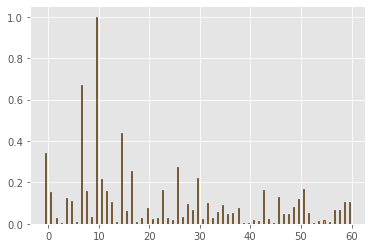

In [27]:
X_indices = np.arange(X_train.shape[-1])
selector = SelectKBest(f_classif, k=30)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(X_indices - .45, scores, width=.2,
        label=r'Univariate score ($-Log(p_{value})$)', color='darkorange',
        edgecolor='black')

We can see that the 10-th feature in our dataset is the most important one according to F-score. This variable correspond to **Comptes_A14** which is when the client has no current account. The second most important feature is **Comptes_A11** which is when the client has less than 0€ on his current account.

# Benchmarking versus other Machine Learning algorithms

## Random Forest

In [10]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

Training Features Shape: (700, 61)
Training Target Shape: (700,)
Testing Features Shape: (300, 61)
Testing Target Shape: (300,)


In [29]:
%%time
rf = RandomForestClassifier()

parameters = {
 'bootstrap':         [True, False],
 'max_depth':         [10, 20, 50, 100],
 'max_features':      ['auto', 'sqrt'],
 'min_samples_leaf':  [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators':      [200, 500, 1000],
 'criterion':         ['gini', 'entropy']
}


#rf_classifier = GridSearchCV(rf, parameters, cv=5, n_jobs = -1)
rf_classifier = rf_classifier.fit(X_train, y_train)

print("Best: %f using %s" % (rf_classifier.best_score_, rf_classifier.best_params_))

Best: 0.778571 using {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 1000}
Wall time: 15min 39s


In [11]:
rf_model = RandomForestClassifier(bootstrap = 'False' ,
                                  max_depth = 50,
                                  max_features = 'auto',
                                  min_samples_leaf = 2,
                                  min_samples_split = 2,
                                  n_estimators = 1000,
                                  criterion = 'entropy')

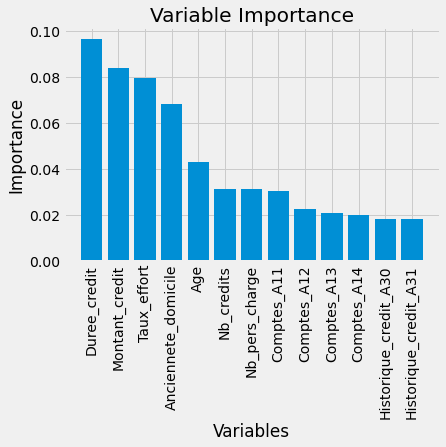

In [12]:
rf_model.fit(X_train,y_train)

# Use the forest's predict method on the test data
predictions = rf_model.predict(X_test)
predictions_prob = rf_model.predict_proba(X_test)

# Get numerical feature importances
importances = sorted(list(rf_model.feature_importances_),reverse=True)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(features_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values[:13], importances[:13], orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values[:13], features_list[:13], rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variables'); plt.title('Variable Importance');

In [13]:
y_pred = rf_model.predict(X_test)
pscore = metrics.accuracy_score(y_test, y_pred)
pscore_f1 = metrics.f1_score(y_test, y_pred)
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(pscore_f1)

[[181  29]
 [ 50  40]]
0.5031446540880502


In [14]:
acc_RF = accuracy_score(y_test, y_pred)
f1_score_RF = f1_score(y_test, y_pred)
recall_score_RF = recall_score(y_test, y_pred)
precision_score_RF = precision_score(y_test, y_pred)
print("Testing Accuracy :  {:.4f}".format(acc_RF))
print("Testing F1-Score :  {:.4f}".format(f1_score_RF))
print("Testing Precision:  {:.4f}".format(precision_score_RF))
print("Testing Recall   :  {:.4f}".format(recall_score_RF))

Testing Accuracy :  0.7367
Testing F1-Score :  0.5031
Testing Precision:  0.5797
Testing Recall   :  0.4444


## Logistic Regression

In [15]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

Training Features Shape: (700, 61)
Training Target Shape: (700,)
Testing Features Shape: (300, 61)
Testing Target Shape: (300,)


In [16]:
logit_classifier = LogisticRegression()
logit_classifier.fit(X_train, y_train);
#score = classifier.score(X_test, y_test)
#print(score)

In [17]:
y_pred = logit_classifier.predict(X_test)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[165  45]
 [ 36  54]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       210
           1       0.55      0.60      0.57        90

    accuracy                           0.73       300
   macro avg       0.68      0.69      0.69       300
weighted avg       0.74      0.73      0.73       300



In [18]:
acc_logit = accuracy_score(y_test, y_pred)
f1_score_logit = f1_score(y_test, y_pred)
recall_score_logit = recall_score(y_test, y_pred)
precision_score_logit = precision_score(y_test, y_pred)
print("Testing Accuracy :  {:.4f}".format(acc_logit))
print("Testing F1-Score :  {:.4f}".format(f1_score_logit))
print("Testing Precision:  {:.4f}".format(precision_score_logit))
print("Testing Recall   :  {:.4f}".format(recall_score_logit))

Testing Accuracy :  0.7300
Testing F1-Score :  0.5714
Testing Precision:  0.5455
Testing Recall   :  0.6000


## Support Vector Classifier - SVC

In [19]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

Training Features Shape: (700, 61)
Training Target Shape: (700,)
Testing Features Shape: (300, 61)
Testing Target Shape: (300,)


In [39]:
%%time
SVClass = SVC()

parameters = {
 'kernel':       ['rbf','linear','poly'],
 'C':            [1,10,100,1000],
 'gamma':        [1e-3, 1e-4],
 'random_state': [1337]
}


#SVC_classifier = GridSearchCV(SVClass, parameters, cv=5)
SVC_classifier = SVC_classifier.fit(X_train, y_train)

print("Best: %f using %s" % (SVC_classifier.best_score_, SVC_classifier.best_params_))

Best: 0.760000 using {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf', 'random_state': 1337}
Wall time: 8min 25s


In [20]:
SVC_model = SVC(kernel='rbf',
                   C = 1000,
                   gamma = 0.001,
                   random_state = 1337)

SVC_model.fit(X_train, y_train)

SVC(C=1000, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=1337, shrinking=True,
    tol=0.001, verbose=False)

In [21]:
y_pred = SVC_model.predict(X_test)

score = SVC_model.score(X_test, y_test)
print(score)
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
CM_SVC = confusion_matrix(y_test, y_pred)
print(CM_SVC)
print(classification_report(y_test,y_pred))

0.7
[[163  47]
 [ 43  47]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       210
           1       0.50      0.52      0.51        90

    accuracy                           0.70       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.70      0.70      0.70       300



In [22]:
acc_SVC = accuracy_score(y_test, y_pred)
f1_score_SVC = f1_score(y_test, y_pred)
recall_score_SVC = recall_score(y_test, y_pred)
precision_score_SVC = precision_score(y_test, y_pred)
print("Testing Accuracy :  {:.4f}".format(acc_SVC))
print("Testing F1-Score :  {:.4f}".format(f1_score_SVC))
print("Testing Precision:  {:.4f}".format(precision_score_SVC))
print("Testing Recall   :  {:.4f}".format(recall_score_SVC))

Testing Accuracy :  0.7000
Testing F1-Score :  0.5109
Testing Precision:  0.5000
Testing Recall   :  0.5222


## XGBoost - Gradient Boosting

In [ ]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

In [24]:
%%time
xgb = XGBClassifier()

parameters = {
 'n_estimators':     [200,500,1000,2000],
 'max_depth':        [3,5,7,10],
 'min_child_weight': [1,3,5,10],
 'learning_rate':    [0.01, 0.05, 0.075, 0.1, 0.15],
 'seed':             [1337],
 'objective':        ['binary:logistic'],
 'nthread' :         [6],
 'njobs':            [-1],
 'eval_metric':      ['logloss']
}


xgb_classifier = GridSearchCV(xgb, parameters, cv=5)
xgb_classifier = xgb_classifier.fit(X_train, y_train,
                                    early_stopping_rounds=10,
                                    eval_set=[(X_test, y_test)],
                                    verbose=False)

print("Best: %f using %s" % (xgb_classifier.best_score_, xgb_classifier.best_params_))

Best: 0.777143 using {'eval_metric': 'logloss', 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 500, 'njobs': -1, 'nthread': 6, 'objective': 'binary:logistic', 'seed': 1337}
Wall time: 3min 26s


In [25]:
xg_model = XGBClassifier(eval_metric = 'logloss',
                         n_estimators=5,
                         learning_rate=0.01,
                         max_depth = 3,
                         min_child_weight = 5,
                         seed = 1337,
                         objective = 'binary:logistic')

xg_model.fit(X_train, y_train,
             early_stopping_rounds=10,
             eval_set=[(X_test, y_test)],
             verbose=False);

In [26]:
y_pred = xg_model.predict(X_test)

from sklearn.metrics import recall_score, classification_report, auc, roc_curve
CM_XGB = confusion_matrix(y_test, y_pred)
print(CM_XGB)

[[182  28]
 [ 57  33]]


In [27]:
acc_XGB = accuracy_score(y_test, y_pred)
f1_score_XGB = f1_score(y_test, y_pred)
recall_score_XGB = recall_score(y_test, y_pred)
precision_score_XGB = precision_score(y_test, y_pred)
print("Testing Accuracy :  {:.4f}".format(acc_XGB))
print("Testing F1-Score :  {:.4f}".format(f1_score_XGB))
print("Testing Precision:  {:.4f}".format(precision_score_XGB))
print("Testing Recall   :  {:.4f}".format(recall_score_XGB))

Testing Accuracy :  0.7167
Testing F1-Score :  0.4371
Testing Precision:  0.5410
Testing Recall   :  0.3667


## Decision Trees

In [28]:
print('Training Features Shape:', X_train.shape)
print('Training Target Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Target Shape:', y_test.shape)

Training Features Shape: (700, 61)
Training Target Shape: (700,)
Testing Features Shape: (300, 61)
Testing Target Shape: (300,)


In [50]:
%%time
clf = DecisionTreeClassifier()

parameters = {
 'min_samples_split': [10,50,100,200,500],
 'max_depth':         [3,5,7,10,20],
 'max_features':      ['auto','sqrt','log2'],
 'random_state':      [1337],
 'criterion':         ['gini', 'entropy']
}

#decision_tree_classifier = GridSearchCV(clf, parameters, cv=5)
decision_tree_classifier = decision_tree_classifier.fit(X_train, y_train)

print("Best: %f using %s" % (decision_tree_classifier.best_score_, decision_tree_classifier.best_params_))

Best: 0.745714 using {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_split': 100, 'random_state': 1337}
Wall time: 984 ms


In [31]:
clf_model = DecisionTreeClassifier(min_samples_split = 100,
                                   max_depth = 5,
                                   max_features = 'log2',
                                   random_state = 1337,
                                   criterion = 'entropy')

clf_model = clf.fit(X_train, y_train);

In [32]:
y_pred = clf_model.predict(X_test)


from sklearn.metrics import recall_score, classification_report, auc, roc_curve
CM_DT = confusion_matrix(y_test, y_pred)
print(CM_DT)

[[146  64]
 [ 45  45]]


In [33]:
acc_DT = accuracy_score(y_test, y_pred)
f1_score_DT = f1_score(y_test, y_pred)
recall_score_DT = recall_score(y_test, y_pred)
precision_score_DT = precision_score(y_test, y_pred)
print("Testing Accuracy :  {:.4f}".format(acc_DT))
print("Testing F1-Score :  {:.4f}".format(f1_score_DT))
print("Testing Precision:  {:.4f}".format(precision_score_DT))
print("Testing Recall   :  {:.4f}".format(recall_score_DT))

Testing Accuracy :  0.6367
Testing F1-Score :  0.4523
Testing Precision:  0.4128
Testing Recall   :  0.5000
